In [8]:
#Импортируем основные библиотеки
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from scipy.stats import bootstrap, chi2_contingency
import pingouin as pg

# Описание задачи:

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [9]:
AB_df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/SOkIsD5A8xlI7Q', sep = ';')

# EDA

In [10]:
shape = AB_df.shape[0]
print(f"количество строк в датафрейме: {shape}")

количество строк в датафрейме: 404770


In [11]:
#Типы данных
dtypes = AB_df.dtypes
print(dtypes)

user_id       int64
revenue       int64
testgroup    object
dtype: object


In [12]:
#Число уникалтные пользователей
unique_users = AB_df.user_id.nunique()
print(f"Число уникальных пользователей: {unique_users}")

Число уникальных пользователей: 404770


In [13]:
#Посмотрим на число уникальных пользователей в двух группах
unique_users_by_group = AB_df\
    .groupby('testgroup')\
    .agg({'user_id' : 'nunique'})\
    .reset_index()
print(f"Число уникальных пользователей в контрольной группе: {unique_users_by_group.user_id[0]}")
print(f"Число уникальных пользователей в тестовой группе: {unique_users_by_group.user_id[1]}")

Число уникальных пользователей в контрольной группе: 202103
Число уникальных пользователей в тестовой группе: 202667


In [14]:
#Посмотрим на описательную статистику по группам
description = AB_df.groupby('testgroup')['revenue'].describe()

# ARPU

ARPU = Revenue / Users (чистый доход «поделить» на количество всех пользователей)

In [15]:
#Подсчет ARPU
ARPU = AB_df\
    .groupby('testgroup')\
    .agg({'revenue' : 'mean'})\
    .reset_index().round(2)

print(f"ARPU в контрольной группе: {ARPU.revenue[0]}")
print(f"ARPU в тестовойгруппе: {ARPU.revenue[0]}")

ARPU в контрольной группе: 25.41
ARPU в тестовойгруппе: 25.41


По условию ARPU в тестовой группе выше на 5%, исходя из расчетов, полученных выше, это, действительно, так.

In [16]:
#Отберем пользователей в группе А
A_group = AB_df.query("testgroup == 'a'")

#Отберем пользователей в группе Б
B_group = AB_df.query("testgroup == 'b'")

Теперь, когда мы получили датафреймы с данными для расчета ARPU в тестовой и контрольной группах, можно приступать к применению статистического теста. В данном случае можно попробовать сравнить средние значения в двух группах с помощью t-критерия Стьюдента для независимых выборок, однако, как мы знаем из теории, у него есть несколько условий:

1. Сравниваемые значения не составляют пару коррелирующих значений(выполнено);

2. Распределение признаков в каждой выборке соответствует нормальному распределению(тест Шапиро-Уилка), однако некоторые эксперты считают, что данный пункт не обязателем при больших выборках;

3. Дисперсии признака в выборках примерно равны (проверяется с помощью критерия Ливиня)

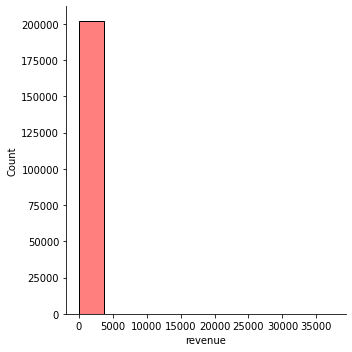

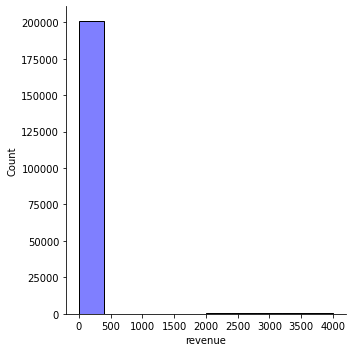

In [17]:
#Построим графики распределения выручки со всех пользователей для двух групп
sns.displot(A_group['revenue'], bins=10, label='Группа A', color = 'red', alpha = 0.5)
sns.displot(B_group['revenue'], bins = 10, label='Группа B', color = 'blue', alpha = 0.5)

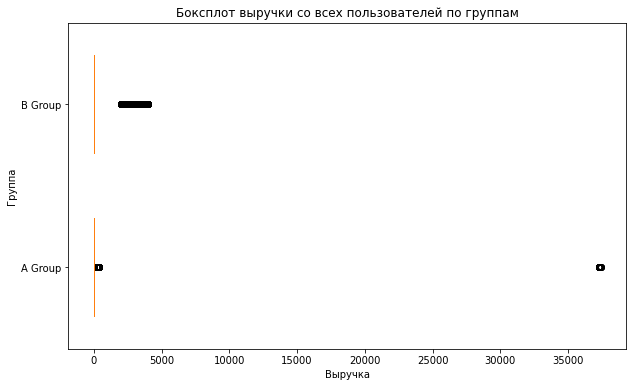

In [18]:
# Построение боксплотов
plt.figure(figsize=(10, 6))

# Боксплот для A_group
plt.boxplot(A_group['revenue'], positions=[1], widths=0.6, vert=False, patch_artist=True, boxprops=dict(facecolor='lightcoral'))
# Боксплот для B_group
plt.boxplot(B_group['revenue'], positions=[2], widths=0.6, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))

plt.yticks([1, 2], ['A Group', 'B Group'])
plt.title('Боксплот выручки со всех пользователей по группам')
plt.ylabel('Группа')
plt.xlabel('Выручка')

plt.show()

На графиках видно, что распределение сильно отличается от нормального. К тому же при расчете метрики "ARPU" мы вынуждены оставить в датафрейме пользователей, которые не платят, то есть у которых revenue = 0. Как видно на графике(боксплот), наибольшее количество пользователей не являются покупателями,то есть нули составляют большую часть выборки.

Боксплот показал, что медиана лежит у нуля, поэтому привычный формат графика не вырисовывается. 

Несмотря на то, что в выборке довольно большое количество наблюдений, и можно было бы использовать **t-test**, в данном проекте я бы этого не делал, а отдал предпочтение другому методу, о котором речь пойдет ниже. В статистике рекомендуется применять **Mann-Whitney U test** для анализа данных в такой ситуации, однако эксперты рекомендуют применять его с осторожностью, так как он не проверяет средние значения в двух выборках.

Как мне кажется, оптимальным вариантом в этом случае будет **bootstap**, однако в случае ARPU есть одно большое ограничение в виде размера датафрейма. К примеру, в группе "А" порядка  202103 заказов, и если мы будем ресемплить 10000 раз revenue, то это займет крайне большое количество времени(проверял). В таком случае мы можем снизить количество выборок для скорости вычисления, но это, разумеется, скажется на точности теста. 

В итоге я бы использовал bootstrap с 500-1000 выборками. Ну и для того, чтобы точно убедиться в ненормальности распределения переменной, проверим с помощью теста Шапиро-Уилка

In [19]:
#P-value < 0.05 следовательно у нас есть достаточно доказательств, чтобы сказать, что данные выборки не получены из нормального распределения.
statistic_control, pvalue_control = stats.shapiro(A_group['revenue'])
statistic_test, pvalue_test = stats.shapiro(B_group['revenue'])

if pvalue_control < 0.05:
    print("Распределение отличается от нормального в контрольной группе.")
else:
    print("Распределение соотвествует нормальному в контрольной группе") 
    
if pvalue_test < 0.05:
    print("Распределение отличается от нормального в тестовой группе.")
else:
    print("Распределение соотвествует нормальному в тестовой группе") 

Распределение отличается от нормального в контрольной группе.
Распределение отличается от нормального в тестовой группе.


/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Далее сравним доверительные интервалы среднего значения двух бутстрапированных выборок

Выдвинем следюущие гипотезы: 

​
$H_0$
​
  – ноль попадает в доверительный интервал разности ARPU(значимые различия не обнаружены)

$H_1$
​
  – ноль не попадает в доверительный интервал разности ARPU(значимые различия обнаружены)
​

In [20]:
#Создадим пустой список для хранения разности средних
mean_diff = []

#бутстрэп
n_resamples = 1000
for i in range(n_resamples):
    
    # Случайная выборка с возвращением для контрольной группы
    sample_data_control = A_group['revenue'].sample(frac=0.5, replace=True)
    
    # Случайная выборка с возвращением для экспериментальной группы
    sample_data_exp = B_group['revenue'].sample(frac=0.5, replace=True)
    
    # Вычисляем разность средних
    sample_mean_diff = sample_data_exp.mean() - sample_data_control.mean()
    mean_diff.append(sample_mean_diff)

mean_diff = np.array(mean_diff)

# Вычисляем доверительный интервал
lower_bound = np.percentile(mean_diff, 2.5)  # 2.5-й перцентиль
upper_bound = np.percentile(mean_diff, 97.5)  # 97.5-й перцентиль

print(f"Доверительный интервал разности ARPU в двух группах: ({lower_bound}, {upper_bound})")

if lower_bound <= 0 <= upper_bound:
    print("Ноль попадает в 95% доверительный интервал расности ARPU: нет статистически значимых различий между группами.")
else:
    print("Ноль не попадает в 95% доверительный интервал: есть статистически значимые различия между группами.")

Доверительный интервал разности ARPU в двух группах: (-4.598621879086083, 6.6873410465024685)
Ноль попадает в 95% доверительный интервал расности ARPU: нет статистически значимых различий между группами.


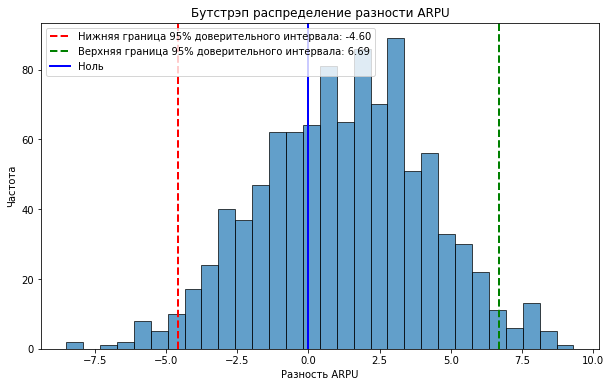

In [21]:
#Построим график для наглядности
mean_diff = np.array(mean_diff)

lower_bound = np.percentile(mean_diff, 2.5)
upper_bound = np.percentile(mean_diff, 97.5)

plt.figure(figsize=(10, 6))
plt.hist(mean_diff, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(lower_bound, color='red', linestyle='--', linewidth=2, label=f'Нижняя граница 95% доверительного интервала: {lower_bound:.2f}')
plt.axvline(upper_bound, color='green', linestyle='--', linewidth=2, label=f'Верхняя граница 95% доверительного интервала: {upper_bound:.2f}')
plt.axvline(0, color='blue', linestyle='-', linewidth=2, label='Ноль')
plt.title('Бутстрэп распределение разности ARPU')
plt.xlabel('Разность ARPU')
plt.ylabel('Частота')
plt.legend()
plt.show()

Расчитанный 95% доверительный интервал для разности ARPU в двух группах показал, что ноль попадает в него,а следовательно у нас достаточно оснований для того, чтобы принять нулевую гипотзу(H0) и сказать, что  в генеральной совокупности в контрольной и тестовой группах ARPU не различаются 

# ARPPU

Рассмотрим следующую метрику: **ARPPU**

ARPPU = Revenue / Paying Users (чистый доход «поделить» на количество платящих пользователей)

Расчет этой метрики в датафрейме не потрбуется, ведь фактически можно отобрать заказы платящих пользователей и посчитать по ним сумму, именно таким способом можно получить ARPPU

Алгоритм действий будет идентчиен метрики ARPU: расчитаем 95% доверительный интервал разности ARPPU и посмотрим, попадает ли ноль в этот доверительный интервал, но перед этим снова попробуем проверить на нормальность выборки из платящих пользователей

Начнем с проверки на нормальность:

In [22]:
#Также немаловажным при расчете данной метрики избавиться от неплатящих игроков
A_group_2 = A_group.query("revenue > 0")
B_group_2 = B_group.query("revenue > 0")

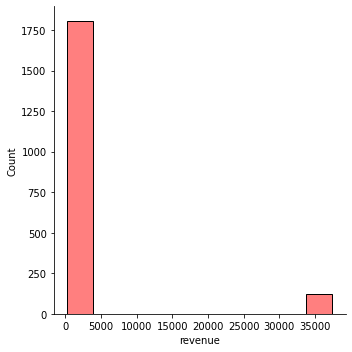

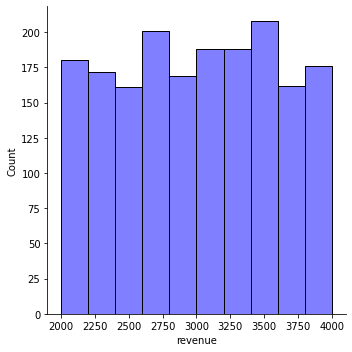

In [23]:
#Построим графики распределения выручки с платчщих пользователей в двух группах
sns.displot(A_group_2['revenue'], bins=10, label='Группа A', color = 'red', alpha = 0.5)
sns.displot(B_group_2['revenue'], bins = 10, label='Группа B', color = 'blue', alpha = 0.5)

Собственно как и в случае с ARPU игроки в первой группе совершают покупки на меньшую сумму(за исключением нескольких крупных покупок), а вот в тестовой наоборот - сумма, как правило, выше, именно поэтому за счет крупных покупок у ряда пользователей в контрольной группе, среднее значение находится приблизительно на одном уровне в выборках. 

Если мы посмотрим на данные из группы "A" чуть ближе,то сможем выделить кластеры на основе выручки, которыую принесли пользователи. Как и было сказано ранее, в контрольной группе есть пользователи, которые совершают небольшие покупки, а есть пользователи, которые делают покупки на большие суммы. В дальнейшем можно было бы ознакомиться с данным вопросом подробнее и попытаться выделить эти кластеры.

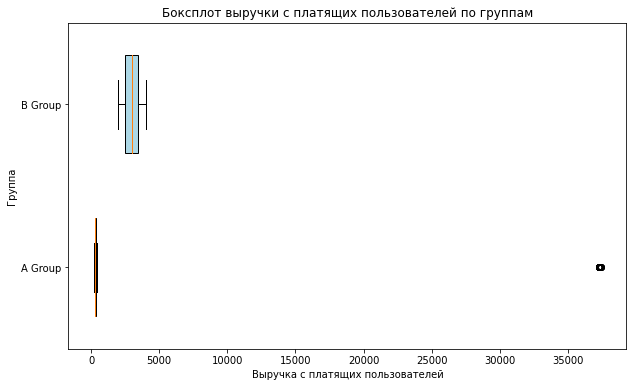

In [24]:
# Построение боксплотов
plt.figure(figsize=(10, 6))

# Боксплот для A_group
plt.boxplot(A_group_2['revenue'], positions=[1], widths=0.6, vert=False, patch_artist=True, boxprops=dict(facecolor='lightcoral'))
# Боксплот для B_group
plt.boxplot(B_group_2['revenue'], positions=[2], widths=0.6, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))

# Настройка осей и заголовков
plt.yticks([1, 2], ['A Group', 'B Group'])
plt.title('Боксплот выручки с платящих пользователей по группам')
plt.ylabel('Группа')
plt.xlabel('Выручка с платящих пользователей')

plt.show()

Ситуация схожа с метрикой ARPU: в двух группах распределние переменной сильно отличется от нормального, медиана в тестовой группе будет лежать в диапазоне 1,7. Также дополнительно проверим результат с помощью статистических тестов(Колмагорова-Смирнова). 

In [25]:
statistic_cotrol, pvalue_control = stats.kstest(A_group_2['revenue'], 'norm', args=(np.mean(A_group_2['revenue']), np.std(A_group_2['revenue']))) 
statistic_test, pvalue_test = stats.kstest(B_group_2['revenue'], 'norm', args=(np.mean(B_group_2['revenue']), np.std(B_group_2['revenue'])))

if pvalue_control < 0.05:
    print("Распределение отличается от нормального в контрольной группе.")
else:
    print("Распределение соотвествует нормальному в контрольной группе") 
    
if pvalue_test < 0.05:
    print("Распределение отличается от нормального в тестовой группе.")
else:
    print("Распределение соотвествует нормальному в тестовой группе")   

Распределение отличается от нормального в контрольной группе.
Распределение отличается от нормального в тестовой группе.


В двух группах p-value оказался меньше порогового значения - 0.05, что говорит о том, что переменные распределены ненормально. В таком случае алгоритм будет идентичным прошлой метрике: воспользуемся **bootstrap**, чтобы сделать вывод о различиях. Перед тем, как приступать к тестам, посмотрим, как выглядят средние значения метрик в двух выборках(группах)

In [26]:
ARPPU_control = A_group_2['revenue'].sum()/1928
ARPPU_test = B_group_2['revenue'].sum()/1805

print(f"Среднее значение ARPPU в контрольной группе {ARPPU_control}")
print(f"Среднее значение ARPPU в тестовой группе {ARPPU_test}")

Среднее значение ARPPU в контрольной группе 2663.9984439834025
Среднее значение ARPPU в тестовой группе 3003.6581717451522


Выдвинем следюущие гипотезы: 

​
$H_0$
​
  – ноль попадет в доверительный интервал разности ARPPU в двух группах(различия не обнаружены)

$H_1$
​
  – ноль не попадает в доверительный интервал разности ARPPU в двух группах(различия обнаружены)
​

In [27]:
#Создадим пустой список для хранения разности средних
mean_diff = []

#бутстрэп
n_resamples = 10000
for i in range(n_resamples):
    
    # Случайная выборка с возвращением для контрольной группы
    sample_data_control = A_group_2['revenue'].sample(frac=1, replace=True)
    
    # Случайная выборка с возвращением для экспериментальной группы
    sample_data_test = B_group_2['revenue'].sample(frac=1, replace=True)
    
    # Вычисляем разность средних
    sample_mean_diff = sample_data_test.mean() - sample_data_control.mean()
    mean_diff.append(sample_mean_diff)

mean_diff = np.array(mean_diff)

# Вычисляем доверительный интервал
lower_bound = np.percentile(mean_diff, 2.5)  # 2.5-й перцентиль
upper_bound = np.percentile(mean_diff, 97.5)  # 97.5-й перцентиль

print(f"95% Доверительный интервал разности средних: ({lower_bound}, {upper_bound})")

if lower_bound <= 0 <= upper_bound:
    print("Ноль попадает в 95% доверительный интервал: нет статистически значимых различий между группами.")
else:
    print("Ноль не попадает 95% в доверительный интервал: есть статистически значимые различия между группами.")


95% Доверительный интервал разности средних: (-74.55006784404779, 741.1184977687032)
Ноль попадает в 95% доверительный интервал: нет статистически значимых различий между группами.


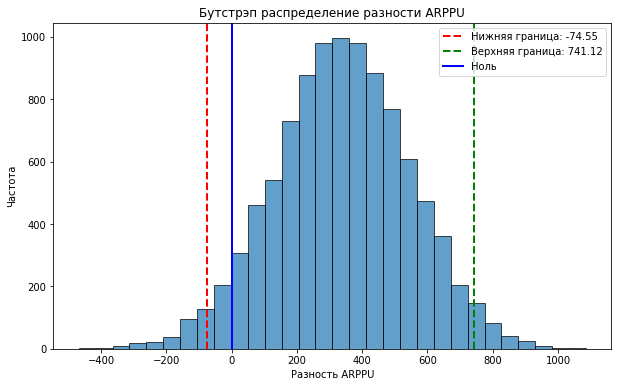

In [28]:
#Построим график для визуализации разности 
mean_diff = np.array(mean_diff)

lower_bound = np.percentile(mean_diff, 2.5)
upper_bound = np.percentile(mean_diff, 97.5)

plt.figure(figsize=(10, 6))
plt.hist(mean_diff, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(lower_bound, color='red', linestyle='--', linewidth=2, label=f'Нижняя граница: {lower_bound:.2f}')
plt.axvline(upper_bound, color='green', linestyle='--', linewidth=2, label=f'Верхняя граница: {upper_bound:.2f}')
plt.axvline(0, color='blue', linestyle='-', linewidth=2, label='Ноль')
plt.title('Бутстрэп распределение разности ARPPU')
plt.xlabel('Разность ARPPU')
plt.ylabel('Частота')
plt.legend()
plt.show()

# Конверсия в покупку

Далее рассмотрим метрику "Конверсия в покупку". В условии дано, что в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. Для того, чтобы сравнить две группы между собой и определить, дейтсвительно ли в генеральной совокупности сохраняется такое соотношение, воспользуется анализом таблиц сопряженности, а именно критерием хи-квадрат Пирсона. Выдвинем следюущие гипотезы:


- $H_0$: В генеральной совокупности нет значимых различий между конверсиями в покупку в тестовой и контрольной группах


- $H_1$: В генеральной совокупности значимые различия между конверсиями в покупку в тестовой и контрольной группах есть


План действий такой: создадим пустой лист, который заполним значениями "buying" и "not buying", где "buying" = revenue>0, а "not buying" = 0, соотвественно. Данный способ облегчит создание таблицы сопряженности, которая нужна для анализа

In [29]:
#Создадим пустой лист
lst = []

#Цикл для отбора нужных строк
for i in AB_df['revenue']:
    if i > 0:
        lst.append('buying')
    else:
        lst.append('not buying')

AB_df['status'] = lst

In [30]:
#Создадим таблицу сопряженности для наглядности 
pd.crosstab(AB_df['status'], AB_df['testgroup'])

testgroup,a,b
status,,
buying,1928,1805
not buying,200175,200862


In [31]:
#Конверсии в покупку в наших выборках
A_group = (1928 /(1928+200175))
B_group = (1805/(1805+200862))
print(f"Конверсия в покупку в контрольной группе: {A_group}")
print(f"Конверсия в покупку в тестовой группе: {B_group}")

Конверсия в покупку в контрольной группе: 0.009539690157988749
Конверсия в покупку в тестовой группе: 0.008906235351586593


In [32]:
#Применим хи-квадрат Пирсона к получившийся сводной таблице
stat, p, dof, expected = chi2_contingency(pd.crosstab(AB_df.status, AB_df.testgroup))
print(stat, p, dof)

4.374729521260405 0.03647561892312613 1


In [33]:
prob = 0.95
alpha = 1.0 - prob
if p < alpha:
    print('Отклоняем H0, В генеральной совокупности значимые различия между конверсиями в покупку в тестовой и контрольной группах есть')
else:
    print('Не отклоняем H0, В генеральной совокупности нет значимых различий между конверсиями в покупку в тестовой и контрольной группах')

Отклоняем H0, В генеральной совокупности значимые различия между конверсиями в покупку в тестовой и контрольной группах есть


Таким образом, мы получили результат p-value < 0.05, а также полученное значение Хи-квадрат(4.4) > критического(3.84), следовательно мы можем отклонить нулевую гипотезу о равенстве конверсий в покупку в тестовой и контрольной группах. Оказалось, что в контрольной группе игроки конвертируются в покупку лучше, чем в тестовой. 

В итоге на данном этапе мы имеем довольно сомнительный результат: метрки ARPU и ARPPU не прокрасились, в то время как метрика "количество покупок" показала, что в контрльной группе платящих пользователей больше, следовательно набор акционных предложений для контрольной группы оказался успешнее. 

Дополнительно можно было бы рассмотреть момент, на который я указывал выше - анализ кластеров в контрольной группе. Воспользуемся подходом, который обычно используется при RFM-сегментации: определим кластеры на основе квантилей.

# Кластеры

In [34]:
quantiles=A_group.query("revenue !=0")['revenue'].quantile(q = [0.25, 0.5, 0.75])
print(quantiles)

AttributeError: 'float' object has no attribute 'query'

В итоге мы получили значения, которые отражают квантили распредления выручки в группе "А". Однако квантили не полностью отражают реальное положение дел: как мы помним из графиков, у нас были значения, которые сильно выбиваются из общей массы - выбросы, где чеки пользователей первышали 30000. 

In [ ]:
#Снова создадим даатфрейм с платящими пользователями
rev_clusters = A_group.query("revenue !=0")

In [ ]:
#Построим график
sns.displot(rev_clusters['revenue'], bins = 10, label='Группа B', color = 'r', alpha = 0.5)

Собственно, мы видим, что отчетливо выделяются два кластера на графике, однако значения, которые меньше 30000 тоже можно поделить на небольшие кластеры. Если мы посмотрем на список этих значений подробнее, то там можно встретить значения от 200 до 400, и, учитывая квантили, которые были использованы выше, можно выделить следующие кластеры по возрастанию выручки: 

1. кластер:  200-257

2. кластер: 257-311

3. кластер: 311-361

4. кластер 361-400

5. кластер: больше 1000

In [ ]:
def cluster_num(x):
    if x >= 200 and x <= 257:
        return 1
    elif x > 257 and x <= 311:
        return 2
    elif x > 311 and x <= 361:
        return 3
    elif x > 361 and x <= 400:
        return 4
    else:
        return 5

In [ ]:
rev_clusters['cluster'] = rev_clusters['revenue'].apply(lambda x: cluster_num(x))

In [ ]:
#Итоговый вариант таблицы
rev_clusters.head()

В итоге мы получили кластеры, которые деляют платящих игроков по выручке, которую они принесли продукту. Для выполнения задания данное действие не требовалось, однако в теории заказчику может потребоваться такая информация о пользователях в будущем.

# Выводы

К сожалению, набор акционных предложений для тестовой группы не может быть использован в продакшене. Гипотезы о различиях метрик ARPU и ARPPU в контрольной и тестовых группах не подствердились, однако анализ метрики "Конверсия в покупку" подтвердил статистически значимые различия в генеральной совокупности между группами, однако не в пользу тестовой: в контрольной группе рользователи конвертируются лучше. Дополнительно я разделил пользователей в контрольной группе на кластеры, что в теории могло бы быть полезно заказчику.